In [32]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
top = mpl.colormaps['Reds_r'].resampled(128)
bottom = mpl.colormaps['Blues'].resampled(128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
residual_cmp = ListedColormap(newcolors, name='RedsBlue')
from matplotlib.patches import Ellipse

In [33]:
import sys
sys.path.insert(0,'../../')
from disk_model import *
from find_center import find_center
from astropy.coordinates import SkyCoord

In [34]:
cb68_alma_list = [
    # '../../data/CB68_FAUST/cb68_setup1_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits',
    # '../../data/CB68_FAUST/cb68_setup2_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits',
    # '../../data/CB68_FAUST/cb68_setup3_all.rob2.I.image.tt0.pbcor.smooth.dropdeg.fits',
    '../../data/CB68_eDisk/CB68_SBLB_continuum_robust_0.0.image.tt0.fits'
]

lambda_list = [
    # 0.13,
    # 0.12,
    # 0.32,
    0.13,
]

sigma_list = [
    # 30e-6,
    # 40e-6,
    # 26e-6,
    21e-6
]

In [35]:
def fit(amax):
    opacity_table = generate_opacity_table_x22(
        a_min=1e-6, a_max=amax*1e-4, # min/max grain size
        q=-3.5, # slope for dust size distribution, dn/da ~ a^q
        dust_to_gas=0.01 # dust-to-gas ratio before sublimation
    )
    disk_property_table = generate_disk_property_table(opacity_table=opacity_table)
    D = DiskFitting('CB68', opacity_table, disk_property_table)
    cosI = np.cos(np.deg2rad(73))
    D.set_cosI(cosI=cosI)
    for i, fname in enumerate(cb68_alma_list):
        ra_deg, dec_deg, disk_pa = find_center(fname, x_lim=[2750,3250], y_lim=[2750,3250])
        # ra_center  = '16:57:19.6428' # from 2d gaussian fitting
        # dec_center = '-16:09:24.013'
        # # Convert WCS to pixel coordinates
        # coord_center = SkyCoord(ra=ra_center, dec=dec_center, unit=('hourangle', 'deg'))
        # ra_deg, dec_deg = coord_center.ra.degree, coord_center.dec.degree
        DI_alma = DiskImage(
            fname = fname,
            ra_deg = ra_deg,
            dec_deg = dec_deg,
            distance_pc = 140,
            rms_Jy = sigma_list[i],
            img_size_au = 60,
            disk_pa=disk_pa,
            remove_background=True
        )
        D.add_observation(DI_alma, lambda_list[i])
    D.fit(weights=None)
    return D, DI_alma, amax

def plot(diskImage):
    fig, ax = plt.subplots(1,3, sharex=True, sharey=False, figsize=(15,5))
    fig.subplots_adjust(left=0.05, right=0.97, top=0.9, bottom=0.1, wspace=0.0, hspace=0.0)

    cb68 = ax[0].imshow(diskImage.img*1e3, cmap='jet', origin='lower', vmin=-0.1, vmax=4)
    colorbar = fig.colorbar(cb68, ax=ax[0], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    ax[0].set_xlabel('AU', fontsize=14)
    ax[0].set_yticks([0, diskImage.img.shape[0]//2, diskImage.img.shape[0]-1])
    ax[0].set_yticklabels([-np.round(diskImage.img_size_au), 0, np.round(diskImage.img_size_au)])
    ax[0].set_ylabel('AU', fontsize=14)
    ax[0].set_title('Observation (1.3 mm)', fontsize=14)

    beam = Ellipse((130, 10), width=diskImage.beam_min_au/diskImage.au_per_pix, height=diskImage.beam_maj_au/diskImage.au_per_pix,
                angle=diskImage.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    ax[0].add_patch(beam)


    # ax[0].contour(diskImage.img, levels=[50*40e-6]ors='black', linewidths=0.65)

    model = ax[1].imshow(diskImage.img_model*1e3, cmap='jet', origin='lower', vmin=-0.1, vmax=4)
    colorbar = fig.colorbar(model, ax=ax[1], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    beam = Ellipse((120, 10), width=diskImage.beam_min_au/diskImage.au_per_pix, height=diskImage.beam_maj_au/diskImage.au_per_pix,
                angle=diskImage.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    ax[1].set_xlabel('AU', fontsize=14)
    ax[1].set_yticks([])
    ax[1].set_title('GIdisk model (fitted by built-in)', fontsize=14)

    beam = Ellipse((130, 10), width=diskImage.beam_min_au/diskImage.au_per_pix, height=diskImage.beam_maj_au/diskImage.au_per_pix,
                angle=diskImage.beam_pa, edgecolor='w', facecolor='w', lw=1.5, fill=True)
    ax[1].add_patch(beam)

    residual = ax[2].imshow((diskImage.img-diskImage.img_model)*1e3, cmap=residual_cmp, origin='lower', vmin=-2, vmax=2)
    colorbar = fig.colorbar(residual, ax=ax[2], pad=0.00, aspect=30, shrink=.98)
    colorbar.set_label('Intensity (mJy/beam)')
    ax[2].set_xticks([0, diskImage.img.shape[0]//2, diskImage.img.shape[0]-1])
    ax[2].set_xticklabels([-np.round(diskImage.img_size_au), 0, np.round(diskImage.img_size_au)])
    ax[2].set_xlabel('AU', fontsize=14)
    ax[2].set_yticks([])
    ax[2].set_title('Residual', fontsize=14)

    beam = Ellipse((130, 10), width=diskImage.beam_min_au/diskImage.au_per_pix, height=diskImage.beam_maj_au/diskImage.au_per_pix,
                angle=diskImage.beam_pa, edgecolor='k', facecolor='k', lw=1.5, fill=True)
    ax[2].add_patch(beam)
    

In [36]:
D, diskImage, amax = fit(amax=150) # um

In [37]:
print('M_star [M_sun] =',D.disk_model.Mstar/Msun)
print('R_disk [au] =',D.disk_model.Rd/au)
print('M_dot [M_sun/yr] =', D.disk_model.Mdot/Msun*yr)

M_star [M_sun] = 0.18864787757688553
R_disk [au] = 32.299279179133464
M_dot [M_sun/yr] = 1.9953233214481202e-06


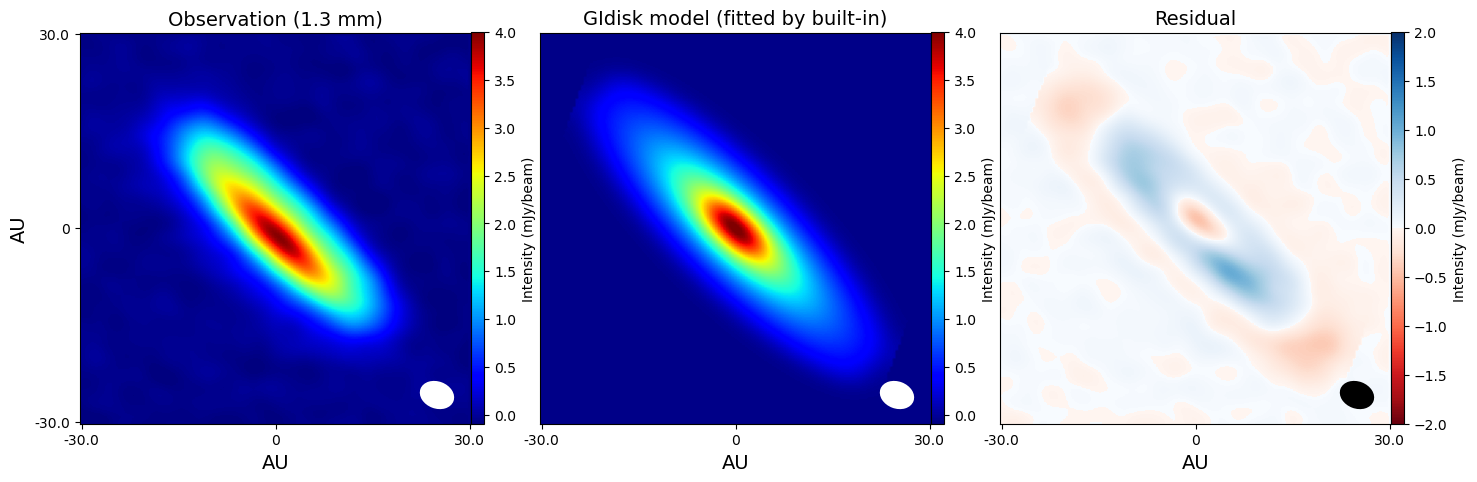

In [38]:
plot(diskImage)

In [39]:
plt.savefig(f'residual_{amax}.pdf', transparent=True)

<Figure size 640x480 with 0 Axes>